Import


In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bc = pd.read_csv('seatle.csv')

## Selection des batiments non residentiels

In [187]:
print(f"Nombre totale de batiments: {len(bc)}")
bc = bc[~bc['BuildingType'].str.contains('Multifamily', na=False)]
print(f"Nombre de batiments non residentiels: {len(bc)}")

Nombre totale de batiments: 3376
Nombre de batiments non residentiels: 1668


# TRAITEMENT DES COLONNES ET DES LIGNES

## Suppression des colonnes vides, avec des données manquantes, à zéro ou constantes
- Comments : Colonne vide
- Outlier : Valeurs manquantes
- YearsENERGYSTARCertified : Valeurs manquantes
- ThirdLargestPropertyUseType : Valeurs manquantes
- ThirdLargestPropertyUseTypeGFA : Valeurs manquantes
- SecondLargestPropertyUseType : Valeurs manquantes
- SecondLargestPropertyUseTypeGFA : Valeurs manquantes
- ENERGYSTARScore : Valeurs manquantes
- DataYear, City, State : Valeurs constantes
- OSEBuildingID, PropertyName, Address, TaxParcelIdentificationNumber, LargestPropertyUseType, LargestPropertyUseTypeGFA, DefaultData, CouncilDistrictCode, Latitude, Longitude : Valeurs non pertinentes,

In [188]:
print(f"Colonnes: {bc.shape[1]}")

bc.isnull().sum().sort_values(ascending=False)
# Suppression des colonnes avec plus de 500 données manquantes
bc = bc.loc[:, bc.isnull().sum() <= 500]
bc.isnull().sum().sort_values(ascending=False)

# Suppression des colonnes avec des données constantes
bc.columns[bc.nunique() == 1].tolist()
bc.drop((['DataYear','City','State']), axis=1, inplace=True)

# Suppression des colonnes non pertinentes
bc.drop((['OSEBuildingID','PropertyName','Address','TaxParcelIdentificationNumber','LargestPropertyUseType','LargestPropertyUseTypeGFA','DefaultData','CouncilDistrictCode','Latitude','Longitude']), axis=1, inplace=True)

# Suppression des colonnes avec des valeurs à 0
(bc == 0).sum().sort_values(ascending=False)
bc.drop((['SteamUse(kBtu)']), axis=1, inplace=True)

print(f"Colonnes: {bc.shape[1]}")

Colonnes: 46
Colonnes: 24


## Suppression des lignes avec des données manquantes

In [189]:
bc.isnull().sum().sort_values(ascending=False)
bc.dropna(subset=['SiteEUI(kBtu/sf)'], inplace=True)
bc.dropna(subset=['SiteEUIWN(kBtu/sf)'], inplace=True)
bc.isnull().sum().sort_values(ascending=False)

ZipCode                      16
BuildingType                  0
SourceEUI(kBtu/sf)            0
TotalGHGEmissions             0
ComplianceStatus              0
NaturalGas(kBtu)              0
NaturalGas(therms)            0
Electricity(kBtu)             0
Electricity(kWh)              0
SiteEnergyUseWN(kBtu)         0
SiteEnergyUse(kBtu)           0
SourceEUIWN(kBtu/sf)          0
SiteEUIWN(kBtu/sf)            0
PrimaryPropertyType           0
SiteEUI(kBtu/sf)              0
ListOfAllPropertyUseTypes     0
PropertyGFABuilding(s)        0
PropertyGFAParking            0
PropertyGFATotal              0
NumberofFloors                0
NumberofBuildings             0
YearBuilt                     0
Neighborhood                  0
GHGEmissionsIntensity         0
dtype: int64

## Traitement des quartiers
- Certains quartiers sont en minuscules et 1 quartier "DELRIDGE NEIGHBORHOODS" peut etre modifié en "DELRIDGE"

In [190]:
print(bc.groupby(['Neighborhood']).size().sort_values(ascending=False))

# Mettre les valeurs en MAJUSCULE
bc['Neighborhood'] = bc['Neighborhood'].str.upper()

# Modifier le quartier "DELRIDGE NEIGHBORHOODS")" en "DELRIDGE"
bc.loc[bc['Neighborhood'] == "DELRIDGE NEIGHBORHOODS", 'Neighborhood'] = "DELRIDGE"

print(bc.groupby(['Neighborhood']).size().sort_values(ascending=False))

Neighborhood
DOWNTOWN                  358
GREATER DUWAMISH          346
MAGNOLIA / QUEEN ANNE     151
LAKE UNION                148
NORTHEAST                 127
EAST                      121
NORTHWEST                  81
BALLARD                    64
NORTH                      58
CENTRAL                    51
SOUTHEAST                  46
DELRIDGE                   42
SOUTHWEST                  41
North                       9
Ballard                     6
Central                     5
Northwest                   5
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
dtype: int64
Neighborhood
DOWNTOWN                 358
GREATER DUWAMISH         346
MAGNOLIA / QUEEN ANNE    151
LAKE UNION               148
NORTHEAST                127
EAST                     121
NORTHWEST                 86
BALLARD                   70
NORTH                     67
CENTRAL                   56
DELRIDGE                  47
SOUTHEAST                 46
SOUTHWEST                 41
dtype: int64


## Traitement des codes postaux
- Sur les ZIPCODE manquants, on peut récupérer le quartier et ajouter le ZIPCODE le plus probable.

In [191]:
######## Traitement des ZipCode manquants ##########
prob = bc.groupby(['ZipCode', 'Neighborhood']).size().reset_index(name='Count')
prob = prob.loc[prob.groupby('Neighborhood')['Count'].idxmax()]
prob = prob[prob['Count'] > 10]
prob = prob.sort_values('Count', ascending=False)
print(prob)

bc = bc.merge(prob[['Neighborhood', 'ZipCode']], on='Neighborhood', how='left', suffixes=('', '_fill'))
bc['ZipCode'] = bc['ZipCode'].fillna(bc['ZipCode_fill'])
bc = bc.drop(columns=['ZipCode_fill'])

bc.isnull().sum().sort_values(ascending=False)

    ZipCode           Neighborhood  Count
76  98134.0       GREATER DUWAMISH    178
8   98101.0               DOWNTOWN    132
24  98105.0              NORTHEAST     80
34  98109.0             LAKE UNION     76
54  98119.0  MAGNOLIA / QUEEN ANNE     63
61  98122.0                   EAST     58
28  98107.0                BALLARD     48
72  98133.0              NORTHWEST     48
65  98125.0                  NORTH     45
60  98122.0                CENTRAL     35
53  98118.0              SOUTHEAST     29
26  98106.0               DELRIDGE     25
48  98116.0              SOUTHWEST     23


BuildingType                 0
PrimaryPropertyType          0
TotalGHGEmissions            0
ComplianceStatus             0
NaturalGas(kBtu)             0
NaturalGas(therms)           0
Electricity(kBtu)            0
Electricity(kWh)             0
SiteEnergyUseWN(kBtu)        0
SiteEnergyUse(kBtu)          0
SourceEUIWN(kBtu/sf)         0
SourceEUI(kBtu/sf)           0
SiteEUIWN(kBtu/sf)           0
SiteEUI(kBtu/sf)             0
ListOfAllPropertyUseTypes    0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
PropertyGFATotal             0
NumberofFloors               0
NumberofBuildings            0
YearBuilt                    0
Neighborhood                 0
ZipCode                      0
GHGEmissionsIntensity        0
dtype: int64

# OUTLIERS


Fonction d'analyse IQR

In [192]:
def analyze_iqr(data, name="Dataset"):
    """Comprehensive IQR analysis of a dataset"""
    print(f"\n{name} Analysis:")
    print("-" * 30)

    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)  # Median
    q3 = np.percentile(data, 75)
    iqr = q3-q1

    print(f"Count: {len(data)}")
    print(f"Min: {min(data)}")
    print(f"Q1 (25%): {q1}")
    print(f"Q2 (50%, Median): {q2}")
    print(f"Q3 (75%): {q3}")
    print(f"Max: {max(data)}")
    print(f"IQR: {iqr}")
    print(f"IQR as % of range: {iqr / (max(data) - min(data)) * 100:.1f}%")

    # Outlier analysis
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [x for x in data if x < lower_bound or x > upper_bound]

    print(f"Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"Number of outliers: {len(outliers)}")
    if outliers:
        print(f"Outlier values: {outliers}")
    return outliers


## Traitement des outliers
- NumberofBuildings : Max 111 >>> CAMPUS >>> Suppression de la donnée car aberrant
- NumberofBuildings : Remplacer 0 par 1 car il y a au moins 1 batiment pour chaque ligne
- NumberofFloors : Max 99 >>> CHURCH >>> Modification à 1 étage
- ElectricitykWh : Min -33826.80078 Max 80460872 >>> Valeur aberrante
- TotalGHGEmissions : Min -0,8 / Max 16870,98 >>> Valeur aberrante

104     27.0
1096    23.0
161     14.0
127     11.0
1159    10.0
Name: NumberofBuildings, dtype: float64
227    63
286    56
265    55
223    49
215    47
Name: NumberofFloors, dtype: int64
470    19859480.0
467    18705198.0
184    18228948.0
980    18075270.0
227    18046946.0
Name: Electricity(kWh), dtype: float64
502    0.0
419    0.0
151    0.0
664    0.0
27     0.0
Name: Electricity(kWh), dtype: float64
1054    3278.11
980     3243.48
1057    3238.24
256     2573.75
1579    2549.47
Name: TotalGHGEmissions, dtype: float64
664    0.0
27     0.0
151    0.0
939    0.0
502    0.0
Name: TotalGHGEmissions, dtype: float64

NumberofBuildings Analysis:
------------------------------
Count: 1650
Min: 1.0
Q1 (25%): 1.0
Q2 (50%, Median): 1.0
Q3 (75%): 1.0
Max: 27.0
IQR: 0.0
IQR as % of range: 0.0%
Outlier bounds: [1.00, 1.00]
Number of outliers: 47
Outlier values: [3.0, 2.0, 4.0, 27.0, 3.0, 11.0, 14.0, 4.0, 3.0, 2.0, 2.0, 6.0, 5.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 2.0, 5.0, 2.0, 5.0, 2

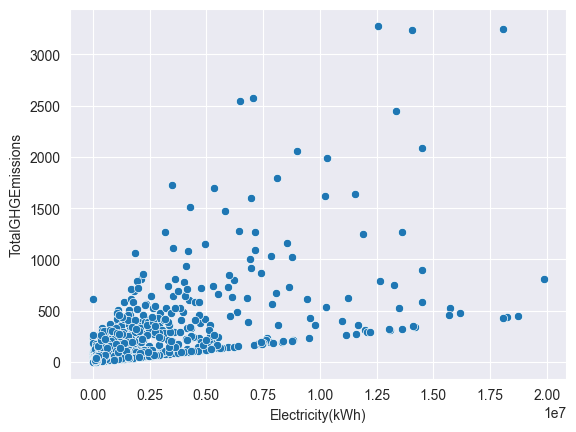

/var/folders/hm/xkkm6rp16357jgy5gn4qpdnw0000gn/T/ipykernel_7202/2274292298.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=prob, x='NumberofFloors', y='Count', palette='viridis', legend=False)


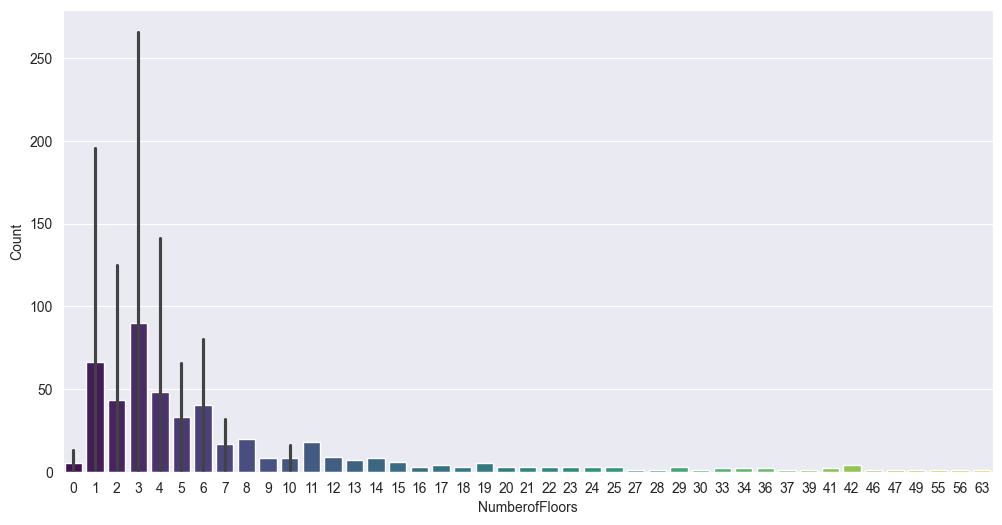

In [196]:
# NumberofBuildings
bc = bc.drop(bc.loc[bc['NumberofBuildings'] == 111].index)
bc.loc[bc['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1
# NumberofFloors
bc.loc[bc['NumberofFloors'] == 99, 'NumberofFloors'] = 1
# ElectricitykWh
bc = bc.drop(bc.loc[bc['Electricity(kWh)'] < 0 ].index)
bc = bc.drop(bc.loc[bc['Electricity(kWh)'] > 20000000].index)

# TotalGHGEmissions
bc = bc.drop(bc.loc[bc['TotalGHGEmissions'] > 3500 ].index)

print(bc['NumberofBuildings'].sort_values(ascending=False).head(5))
print(bc['NumberofFloors'].sort_values(ascending=False).head(5))
print(bc['Electricity(kWh)'].sort_values(ascending=False).head(5))
print(bc['Electricity(kWh)'].sort_values(ascending=True).head(5))
print(bc['TotalGHGEmissions'].sort_values(ascending=False).head(5))
print(bc['TotalGHGEmissions'].sort_values(ascending=True).head(5))

NumberofBuildings = analyze_iqr(bc['NumberofBuildings'], "NumberofBuildings")
NumberofFloors = analyze_iqr(bc['NumberofFloors'], "NumberofFloors")
ElectricitykWh = analyze_iqr(bc['Electricity(kWh)'], "Electricity(kWh)")
TotalGHGEmissions = analyze_iqr(bc['TotalGHGEmissions'], "TotalGHGEmissions")

sns.scatterplot(x='Electricity(kWh)',y='TotalGHGEmissions',data=bc)
plt.show()

plt.figure(figsize=(12,6))
prob = bc.groupby(['NumberofFloors', 'NumberofBuildings']).size().reset_index(name='Count')
prob.sort_values(by=['Count'], ascending=False)
sns.barplot(data=prob, x='NumberofFloors', y='Count', palette='viridis', legend=False)
plt.show()
